In [1]:
from data_utils import *
from model_utils import *
from interval_model import *
from train_test import *
import gc

# sanity checks

In [3]:
#Memory Checks
from collections import Counter

def get_object_counts():
    return Counter(type(obj).__name__ for obj in gc.get_objects())

#model loader
initial_objects = get_object_counts()
model = load_model()

#interval model converter
interval_model = IntervalModel(model)

del model
del interval_model
gc.collect()

remaining_objects = get_object_counts()
diff = remaining_objects - initial_objects
print("Object count differences:")
for obj_type, count in diff.items():
    if count != 0:
        print(f"{obj_type}: {count}")

#Memory Checks CUDA
initial_objects = get_object_counts()
initial_allocated = torch.cuda.memory_allocated()

model = load_model()
model = model.to('cuda')
interval_model = IntervalModel(model)

del model
del interval_model
torch.cuda.empty_cache()
gc.collect()

remaining_objects = get_object_counts()
diff = remaining_objects - initial_objects
print("Object count differences in CPU When checking GPU:")
for obj_type, count in diff.items():
    if count != 0:
        print(f"{obj_type}: {count}")
remaining_allocated = torch.cuda.memory_allocated()

if remaining_allocated > initial_allocated:
    print("Memory leak detected GPU")

Object count differences:
ReferenceType: 29
builtin_function_or_method: 26
lock: 1
Counter: 1
Object count differences in CPU When checking GPU:
builtin_function_or_method: 1


cpu memory differences usually do not matter if the differences are small

In [4]:

#model loader
model = load_model()

#interval model converter
interval_model = IntervalModel(model)

#data loader
train_dataloader, test_dataloader = load_dataloader('mnist_data/')

data = next(iter(test_dataloader))
inputs, labels = data
print("Inputs Shape", inputs.shape) #(B, C, H, W)

# model forward
output = model(inputs)

#create interval
epsilon = 0.1
interval = Interval(inputs-epsilon, inputs+epsilon)
# interval model forward
output_interval = interval_model(interval)
assert output.shape == output_interval.lower.shape and output.shape == output_interval.upper.shape #(B, 10)

output = output.flatten().detach().numpy()
output_interval = output_interval.lower.flatten().detach().numpy(), output_interval.upper.flatten().detach().numpy()

for i in range(len(output)):
    if output[i] < output_interval[0][i] or output[i] > output_interval[1][i]:
        print(f'output: {output[i]}, interval: {output_interval[0][i]} ~ {output_interval[1][i]}')
        raise('error')
        break

print('Checking on CUDA')
model = model.cuda()
interval_model = IntervalModel(model).cuda()
inputs = inputs.cuda()
interval = Interval((inputs-epsilon).cuda(), (inputs+epsilon).cuda())
output = model(inputs)
interval_output = interval_model(interval)
assert output.shape == interval_output.lower.shape == interval_output.upper.shape
output = output.flatten().detach().cpu().numpy()
interval_output = interval_output.lower.flatten().detach().cpu().numpy(), interval_output.upper.flatten().detach().cpu().numpy()
for i in range(len(output)):
    if output[i] < interval_output[0][i] or output[i] > interval_output[1][i]:
        print(f'output: {output[i]}, interval: {interval_output[0][i]} ~ {interval_output[1][i]}')
        raise('error')
        break
del model, interval_model, data, inputs, labels, output, output_interval, interval

torch.cuda.empty_cache()
gc.collect()

print("Passed All Checks")

Inputs Shape torch.Size([64, 1, 28, 28])
Checking on CUDA
Passed All Checks


# Robustness(Verification & Adversarial)

### Training for Base and Robust Model

In [8]:
train_dataloader, test_dataloader = load_dataloader('mnist_data/')
base_model = load_model()
base_model.to('cuda')

robust_model = load_model()
robust_model.to('cuda')

#Train using HW1 code

# # Train the base model
train_model(base_model, 30, train_dataloader, enable_defense=False)


#Train the robust model
train_model(robust_model, 30, train_dataloader, enable_defense=True, eps=0.2)



Epoch 0 done, Epoch Loss 313.5113487429917, Time Taken 6.19356894493103
Epoch 1 done, Epoch Loss 142.16197295486927, Time Taken 6.008989572525024
Epoch 2 done, Epoch Loss 103.84226002544165, Time Taken 7.001872777938843
Epoch 3 done, Epoch Loss 82.31326879560947, Time Taken 5.678766965866089
Epoch 4 done, Epoch Loss 69.12193400179967, Time Taken 5.573289155960083
Epoch 5 done, Epoch Loss 58.68500934075564, Time Taken 5.416965961456299
Epoch 6 done, Epoch Loss 53.14543439797126, Time Taken 5.172173500061035
Epoch 7 done, Epoch Loss 45.813794503570534, Time Taken 5.046792268753052
Epoch 8 done, Epoch Loss 40.80135437916033, Time Taken 5.45028829574585
Epoch 9 done, Epoch Loss 37.5779783584876, Time Taken 5.0276477336883545
Epoch 10 done, Epoch Loss 34.54477775498526, Time Taken 4.848768472671509
Epoch 11 done, Epoch Loss 29.095335150894243, Time Taken 4.7348668575286865
Epoch 12 done, Epoch Loss 26.590752813906875, Time Taken 4.738645553588867
Epoch 13 done, Epoch Loss 28.655630004694103

In [9]:
torch.save(base_model.state_dict(), f'weights_base2.pt')
torch.save(robust_model.state_dict(), f'weights_robust2.pt')

### Verify with Epsilon

In [10]:
def VerifyModel(model: IntervalModel, test_dataloader, eps):
    verified_count = 0
    total_count = 0
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        interval = Interval((inputs-eps).cuda(), (inputs+eps).cuda())
        output_interval = model(interval)
        for num in range(len(labels)):
            true_class = labels[num]
            target_lower = output_interval.lower[num][true_class]
            target_upper = output_interval.upper[num][true_class]
            verified = True
            for j in range(10):
                if j != true_class:
                    current_lower = output_interval.lower[num][j]
                    current_upper = output_interval.upper[num][j]
                    diff_lower = target_lower - current_upper
                    if diff_lower < 0:
                        verified = False
                        break
            if verified:
                verified_count += 1
            total_count += 1
    print(f"Verified {verified_count} out of {total_count} samples, {verified_count/total_count*100}%")
    return verified_count, total_count

In [11]:
base_model.eval()
robust_model.eval()

base_interval_model = IntervalModel(base_model)
robust_interval_model = IntervalModel(robust_model)

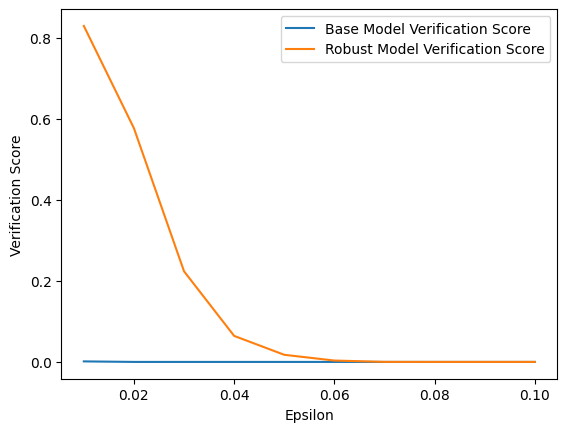

In [15]:
base_accs = []
robust_accs = []
for eps in np.arange(0.01, 0.11, 0.01):
    print(f"Verifying base model with eps={eps}")
    v_count, t_count = VerifyModel(base_interval_model, test_dataloader, eps)
    base_accs.append(v_count/t_count)
    print(f"Verifying robust model with eps={eps}")
    v_count, t_count = VerifyModel(robust_interval_model, test_dataloader, eps)
    robust_accs.append(v_count/t_count)
import matplotlib.pyplot as plt
plt.plot(np.arange(0.01, 0.11, 0.01), base_accs, label='Base Model Verification Score')
plt.plot(np.arange(0.01, 0.11, 0.01), robust_accs, label='Robust Model Verification Score')
plt.xlabel('Epsilon')
plt.ylabel('Verification Score')
plt.legend()
plt.show()


### Adversarial Robustness

In [13]:
for eps in np.arange(0.01, 0.1, 0.01):
    print(f"Verifying base model with epsilon={eps}")
    test_model_on_attacks(base_model, test_dataloader, eps=eps)
    print(f"Verifying robust model with epsilon={eps}")
    test_model_on_attacks(robust_model, test_dataloader, eps=eps)

Verifying base model with epsilon=0.01
Testing Vanilla Accuracy: 0.9717
Testing Attack Accuracy: 0.9096
Testing Robust Accuracy: 0.9096
Verifying robust model with epsilon=0.01
Testing Vanilla Accuracy: 0.9402
Testing Attack Accuracy: 0.9342
Testing Robust Accuracy: 0.9342
Verifying base model with epsilon=0.02
Testing Vanilla Accuracy: 0.9717
Testing Attack Accuracy: 0.773
Testing Robust Accuracy: 0.773
Verifying robust model with epsilon=0.02
Testing Vanilla Accuracy: 0.9402
Testing Attack Accuracy: 0.9273
Testing Robust Accuracy: 0.9273
Verifying base model with epsilon=0.03
Testing Vanilla Accuracy: 0.9717
Testing Attack Accuracy: 0.5651
Testing Robust Accuracy: 0.5651
Verifying robust model with epsilon=0.03
Testing Vanilla Accuracy: 0.9402
Testing Attack Accuracy: 0.9189
Testing Robust Accuracy: 0.9189
Verifying base model with epsilon=0.04
Testing Vanilla Accuracy: 0.9717
Testing Attack Accuracy: 0.3798
Testing Robust Accuracy: 0.3798
Verifying robust model with epsilon=0.04
Tes